---
## Step 1: Setup and Data Collection


Load required libraries and project modules, and define global plotting style and visual conventions used throughout the analysis.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from massive import RESTClient
from scipy import linalg
from datetime import datetime
import warnings

from __future__ import annotations
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.plot_code import set_plot_style

set_plot_style()


Import the list of S&P 500 stocks and the time-window parameters that define the dataset and rolling-window structure.


In [2]:
from modules.config import SP500_TICKERS, START_DATE, END_DATE, EPOCH_SIZE, SHIFT

Download adjusted closing prices for the selected S&P 500 stocks over the specified time period, then clean the dataset by filling missing values and removing stocks or dates with insufficient data.  
The cleaned price matrix defines the set of assets and time range on which subsequent computations are performed.


In [3]:
def fetch_data(tickers, start_date, end_date):
    print(f"Fetching {len(tickers)} stocks from {start_date} to {end_date}...")
    
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=True,
        auto_adjust=True
    )['Close']
    
    data = data.ffill().bfill()
    data = data.dropna(axis=1)
    data = data.dropna(axis=0)

    print(f"Final: {data.shape[0]} trading days, {data.shape[1]} stocks")
    return data

# Fetch data
prices = fetch_data(SP500_TICKERS, START_DATE, END_DATE)
N_STOCKS = prices.shape[1]
print(f"\nN = {N_STOCKS} stocks")

Fetching 166 stocks from 1985-01-02 to 2025-12-31...


[******************    37%                       ]  61 of 166 completed$IPG: possibly delisted; no price data found  (1d 1985-01-02 -> 2025-12-31) (Yahoo error = "No data found, symbol may be delisted")
[*********************100%***********************]  166 of 166 completed

1 Failed download:
['IPG']: possibly delisted; no price data found  (1d 1985-01-02 -> 2025-12-31) (Yahoo error = "No data found, symbol may be delisted")


Final: 10329 trading days, 165 stocks

N = 165 stocks


---
## Step 2: Core Functions (Paper's Methodology)

Key equations from the paper:
- Returns: $r_i(\tau) = \ln P_i(\tau) - \ln P_i(\tau - \Delta)$
- Matrix A: $a_{i,j} = |C_{i,j}|^2$ (to ensure Perron-Frobenius)
- Eigen-centrality: $A|p\rangle = \lambda_1 |p\rangle$ with $\sum_i p_i = 1$
- Eigen-entropy: $H = -\sum_{i=1}^{N} p_i \ln p_i$

Import the core functions that implement the methodology described in the paper: log-returns, correlation matrices, eigenvalue decomposition, eigen-centrality, and entropy measures.


In [4]:
from modules.data_prep import compute_log_returns, compute_correlation_matrix, correlation_to_A_matrix
from modules.entropy import compute_eigen_centrality, compute_entropy
from modules.entropy import decompose_correlation_matrix, compute_three_entropies

---
## Step 3: Single Epoch Demonstration

Compute log-returns from price data and construct the correlation matrix for a single time window (one epoch).  
This provides a concrete example of the objects (returns and correlations).


In [5]:
# Compute returns
returns = compute_log_returns(prices)
print(f"Returns shape: {returns.shape}")

# Single epoch example
sample_returns = returns.iloc[:EPOCH_SIZE].values
C = compute_correlation_matrix(sample_returns)

print(f"\nCorrelation matrix shape: {C.shape}")
print(f"Mean correlation: {C[np.triu_indices(len(C), k=1)].mean():.4f}")

Returns shape: (10328, 165)

Correlation matrix shape: (165, 165)
Mean correlation: 0.1229


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Decompose the correlation matrix into market and group-random components and compute the corresponding eigen-entropies.  
The resulting entropy values and phase-space coordinates illustrate how the paper’s indicators are obtained for one time window.


In [6]:
# Compute three entropies for single epoch
C = (C + C.T) / 2  
np.fill_diagonal(C, 1.0)
H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
ratio = H_GR / H_M

# Maximum entropy (Wishart/WOE limit)
H_max = np.log(C.shape[0])

print(f"N = {N_STOCKS} stocks")
print(f"\nEntropies:")
print(f"  H (full):        {H:.4f}")
print(f"  H_M (market):    {H_M:.4f}")
print(f"  H_GR (group-random): {H_GR:.4f}")
print(f"  H_max (ln N):    {H_max:.4f}")
print(f"\nPhase space coordinates:")
print(f"  |H - H_M|:  {np.abs(H - H_M):.4f}")
print(f"  |H - H_GR|: {np.abs(H - H_GR):.4f}")

lambda1 = eigenvalues[0]  
print(f"Largest eigenvalue (λ₁) = {lambda1:.2f} (MP bound: {(1 + np.sqrt(len(C)/EPOCH_SIZE))**2:.2f})")

N = 165 stocks

Entropies:
  H (full):        4.9097
  H_M (market):    4.6995
  H_GR (group-random): 5.0455
  H_max (ln N):    5.1059

Phase space coordinates:
  |H - H_M|:  0.2102
  |H - H_GR|: 0.1358
Largest eigenvalue (λ₁) = 29.10 (MP bound: 9.19)


Visualize the full correlation matrix together with its market-mode and group-random components obtained from the eigenvalue decomposition.


c:\Users\andre\OneDrive\Desktop\project stuff 1\modules\plot_code.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


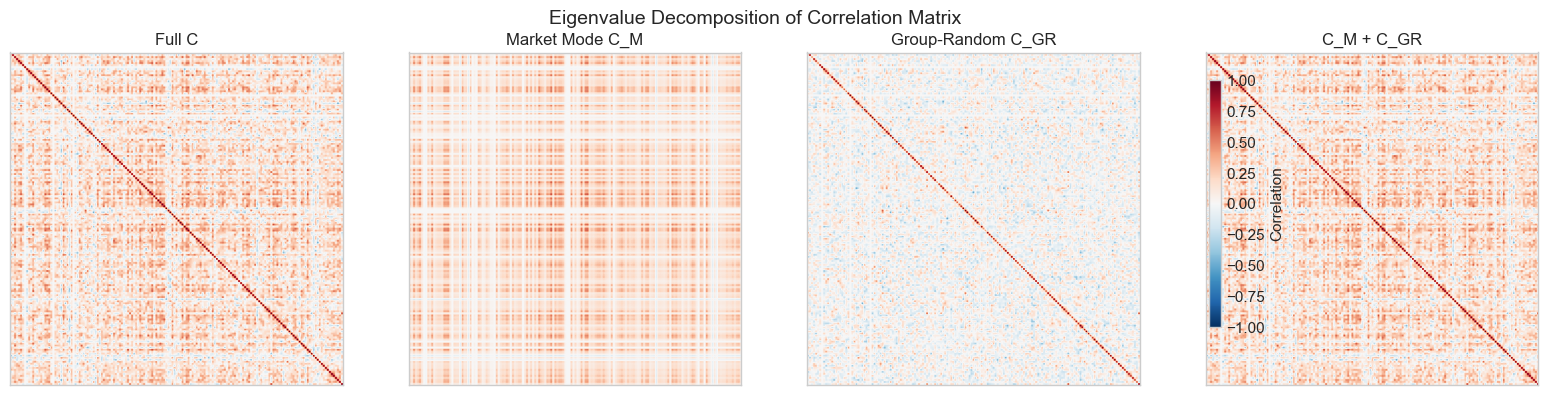

In [7]:
from modules.plot_code import plot_correlation_decomposition

C_M, C_GR, _, _ = decompose_correlation_matrix(C)
plot_correlation_decomposition(C, C_M, C_GR,)

Show representative correlation matrices for selected dates corresponding to different market regimes to illustrate how correlation patterns change across conditions.


c:\Users\andre\OneDrive\Desktop\project stuff 1\modules\plot_code.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


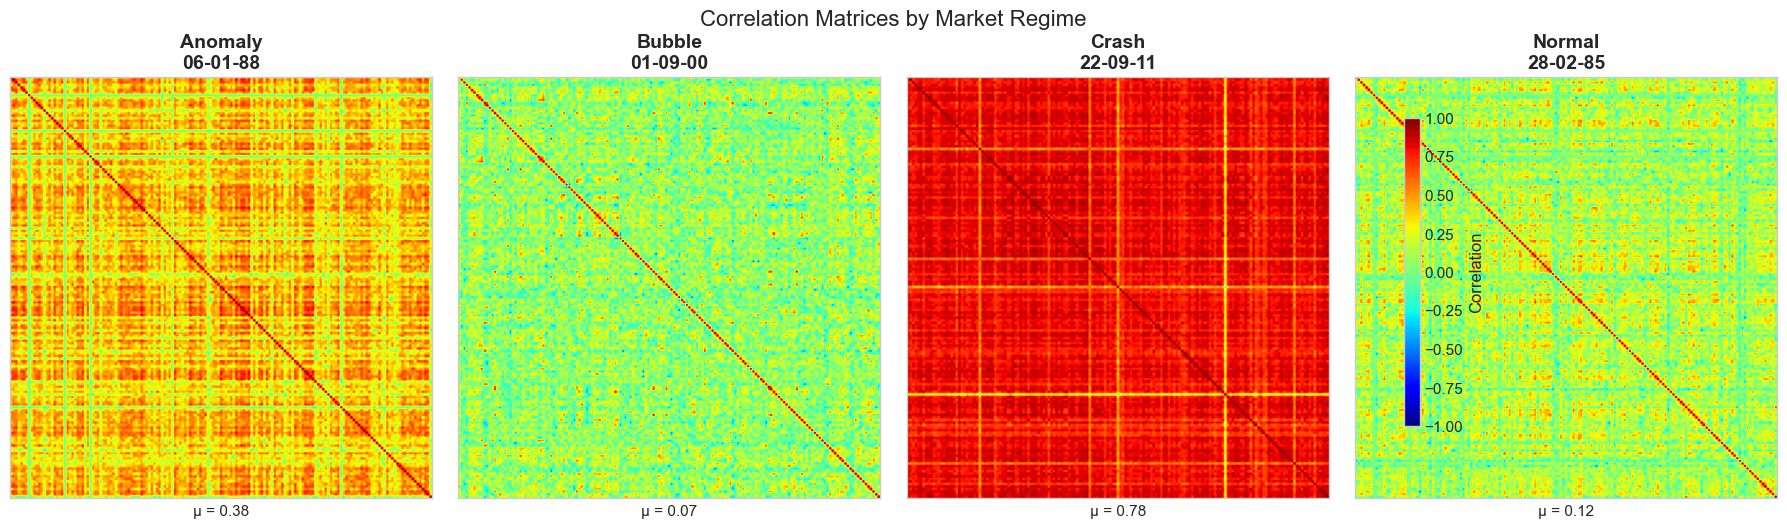

In [8]:
from modules.data_prep import get_correlation_for_date
from modules.plot_code import plot_regime_correlation_matrices
from modules.data_prep import compute_correlation_matrix 

regime_examples = {
    'Anomaly': '1988-01-06',
    'Bubble': '2000-09-01',
    'Crash': '2011-09-22',
    'Normal': '1985-02-28',
}

plot_regime_correlation_matrices(
    returns,
    regime_examples,
    EPOCH_SIZE,
    get_correlation_for_date,
    compute_correlation_matrix)


Compare the ranked eigen-centralities derived from the full correlation matrix and its market and group-random components to highlight differences in node importance across decompositions.


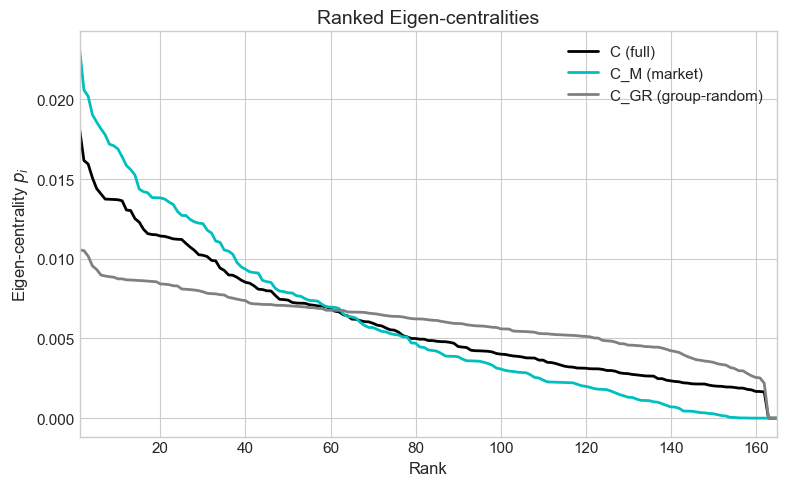

In [9]:
from modules.plot_code import plot_ranked_eigen_centralities
from modules.data_prep import correlation_to_A_matrix
from modules.entropy import compute_eigen_centrality

plot_ranked_eigen_centralities(
    C, C_M, C_GR,
    correlation_to_A_matrix,
    compute_eigen_centrality)


---
## Step 4: Rolling Window Analysis

Apply the entropy and correlation framework over overlapping time windows to track the temporal evolution of market structure.


In [10]:
from modules.entropy import rolling_window_analysis

Compute entropy, correlation, and phase-space quantities for each rolling time window and store them in a structured results table.


In [11]:
results = rolling_window_analysis(
    returns,
    epoch_size=EPOCH_SIZE,
    shift=SHIFT)

results.head(10)


date         H       H_M      H_GR     H_max  H_minus_HM  H_minus_HGR  \
0 1985-02-28  4.909707  4.699529  5.045546  5.105945    0.210178    -0.135839   
1 1985-03-28  4.937836  4.687857  5.048248  5.105945    0.249978    -0.110413   
2 1985-04-26  4.947619  4.656009  5.055271  5.105945    0.291611    -0.107652   
3 1985-05-24  4.923960  4.740414  5.046787  5.105945    0.183546    -0.122827   
4 1985-06-24  4.941717  4.762835  5.046569  5.105945    0.178881    -0.104853   
5 1985-07-23  5.001986  4.704521  5.051469  5.105945    0.297465    -0.049483   
6 1985-08-20  4.959338  4.758506  5.050815  5.105945    0.200832    -0.091478   
7 1985-09-18  4.939988  4.752824  5.038649  5.105945    0.187163    -0.098662   
8 1985-10-17  4.924965  4.744952  5.050985  5.105945    0.180013    -0.126020   
9 1985-11-14  4.935265  4.734667  5.051145  5.105945    0.200597    -0.115881   

   HM_minus_HGR  abs_H_minus_HM  abs_H_minus_HGR        mu  lambda_max  
0     -0.346017        0.210178         0.135839  0.122894   29.101386  
1     -0.360391        0.249978         0.110413  0.110789   26.552114  
2     -0.399262        0.291611         0.107652  0.096560   24.305086  
3     -0.306373        0.183546         0.122827  0.135640   30.917386  
4     -0.283734        0.178881         0.104853  0.137894   30.539830  
5     -0.346948        0.297465         0.049483  0.085594   20.904407  
6     -0.292310        0.200832         0.091478  0.128849   28.552473  
7     -0.285825        0.187163         0.098662  0.137197   30.591897  
8     -0.306033        0.180013         0.126020  0.140745   30.660854  
9     -0.316478        0.200597         0.115881  0.132712   29.384317

---
## Step 5: Regime Identification

Known market events for labeling (from paper's Table S1):

Load the list of known crash and bubble periods from the paper and inspect how many events are used to label market regimes.


In [12]:
from modules.config import MARKET_EVENTS

print(f"Total crash events: {len(MARKET_EVENTS['crashes'])}")
print(f"Total bubble events: {len(MARKET_EVENTS['bubbles'])}")


Total crash events: 14
Total bubble events: 3


Assign calendar-based market regimes (normal, crash, bubble, type-1) to each epoch using the event definitions from the paper, and summarize their distribution.


In [13]:
from modules.entropy import identify_regimes
from modules.config import MARKET_EVENTS

results = identify_regimes(results, MARKET_EVENTS)

print("Regime Distribution:")
print(results['regime'].value_counts())


Regime Distribution:
regime
normal    430
bubble     60
crash      24
type-1      1
Name: count, dtype: int64


---
## Step 6: Reproduce Paper's Figures

Plot the temporal evolution of key market indicators together with known crisis periods and major crash dates, to compare entropy-based signals with historical events.


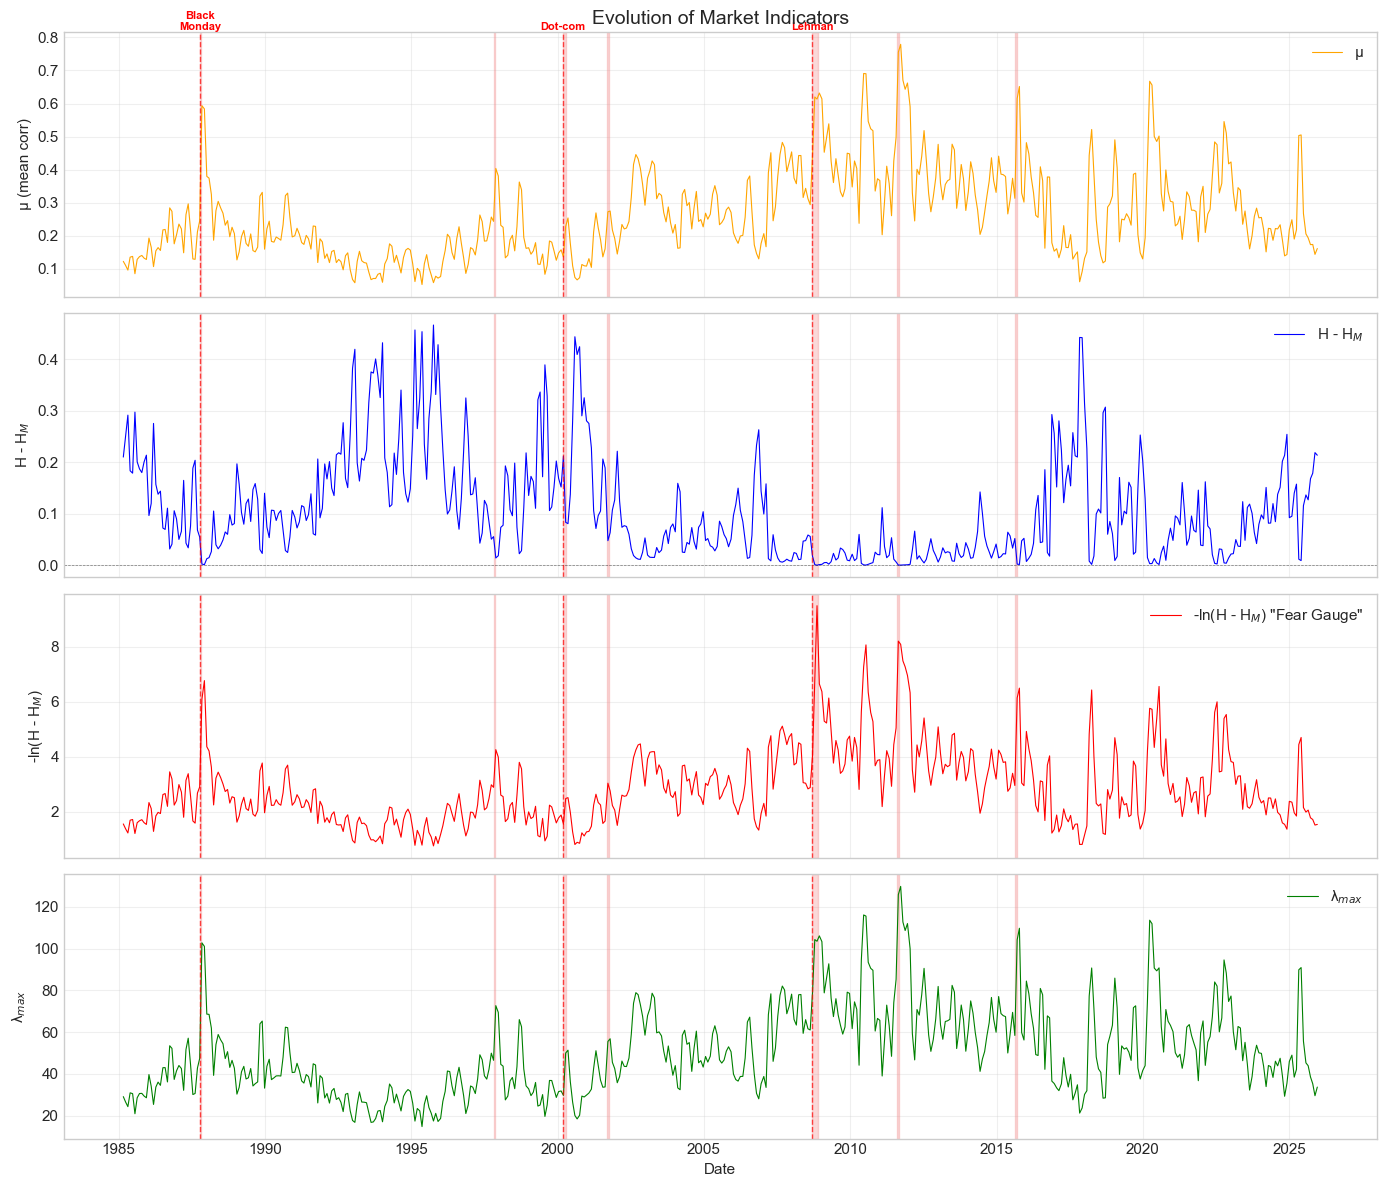

In [14]:
from modules.config import CRISIS_PERIODS, MAJOR_CRASHES
from modules.plot_code import plot_market_indicators

plot_market_indicators(
    results,
    crisis_periods=CRISIS_PERIODS,
    major_crashes=MAJOR_CRASHES
)


Assign phase-space regimes based on entropy differences and test the scaling relation between mean correlation and entropy separation.


Scaling fit: (H - H_M) ~ 0.778 * exp(-9.76 * μ)
Paper values: α ≈ 0.85, β ≈ 10.22


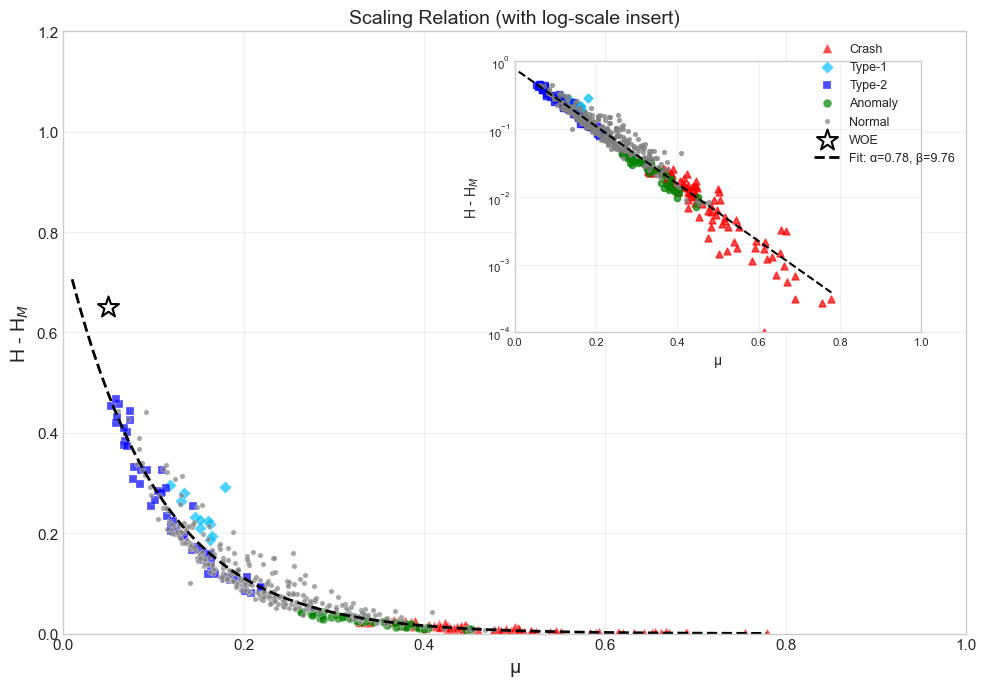

In [15]:
from modules.entropy import assign_phase_regimes_quantiles, fit_scaling_relation
from modules.plot_code import plot_scaling_relation

results_plot, thresholds = assign_phase_regimes_quantiles(results)
fit = fit_scaling_relation(results_plot, verbose=True)
plot_scaling_relation(results_plot, fit=fit)


Visualize the time evolution of entropy differences and highlight periods of unusually high market correlation to examine their relation to known crashes.


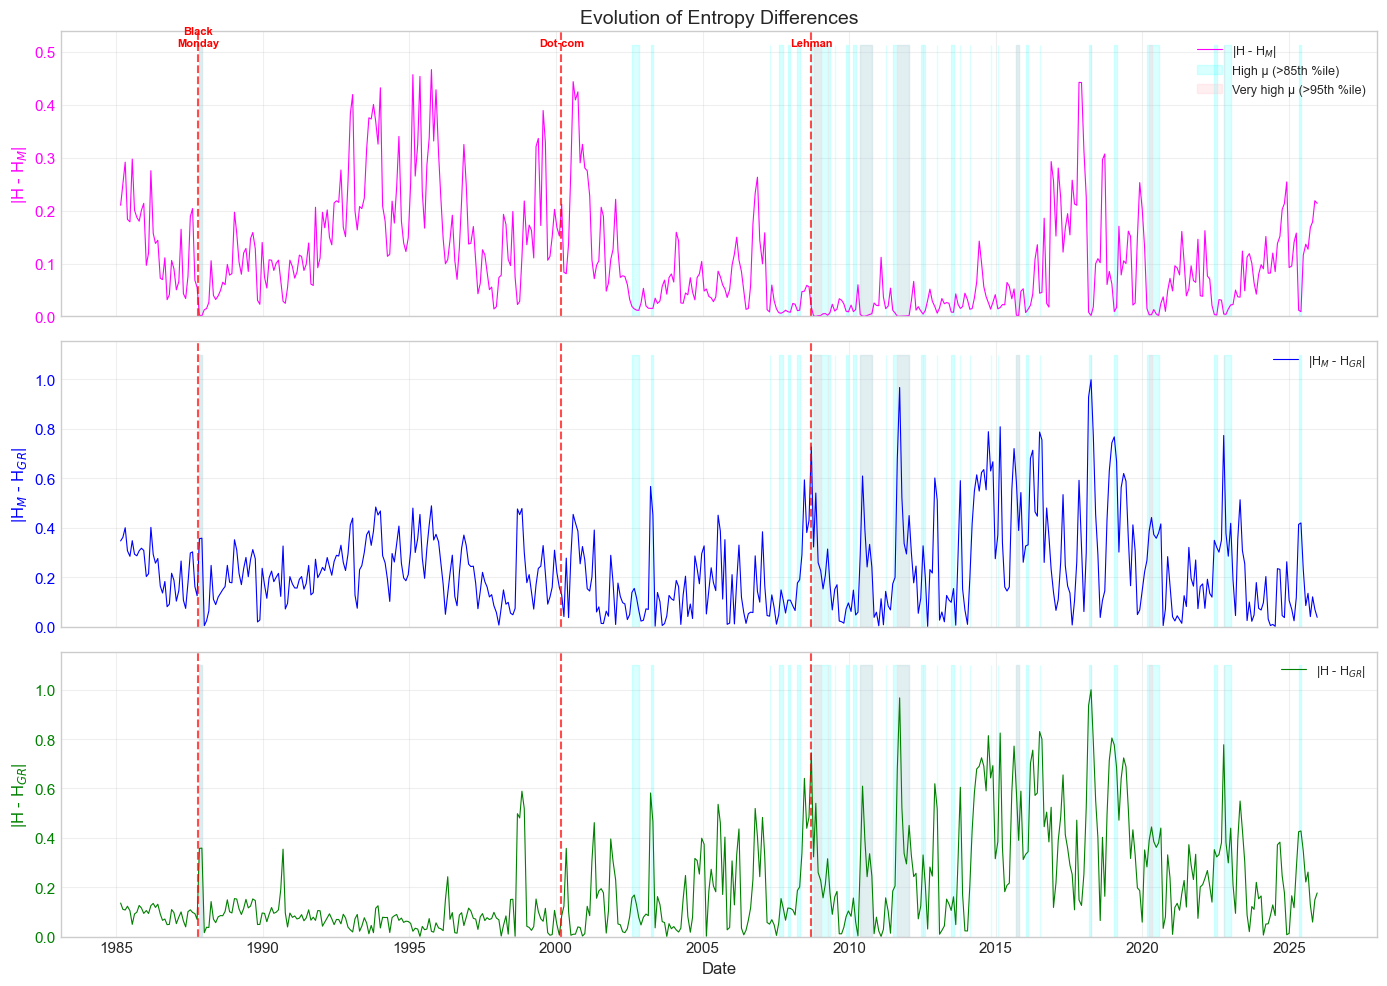

In [16]:
from modules.plot_code import plot_entropy_differences

plot_entropy_differences(
    results,
    crash_dates=MAJOR_CRASHES,
    high_mu_q=0.85,
    very_high_mu_q=0.95)


Show the full temporal evolution of all entropy measures and derived indicators to provide an overview of their long-term behavior.


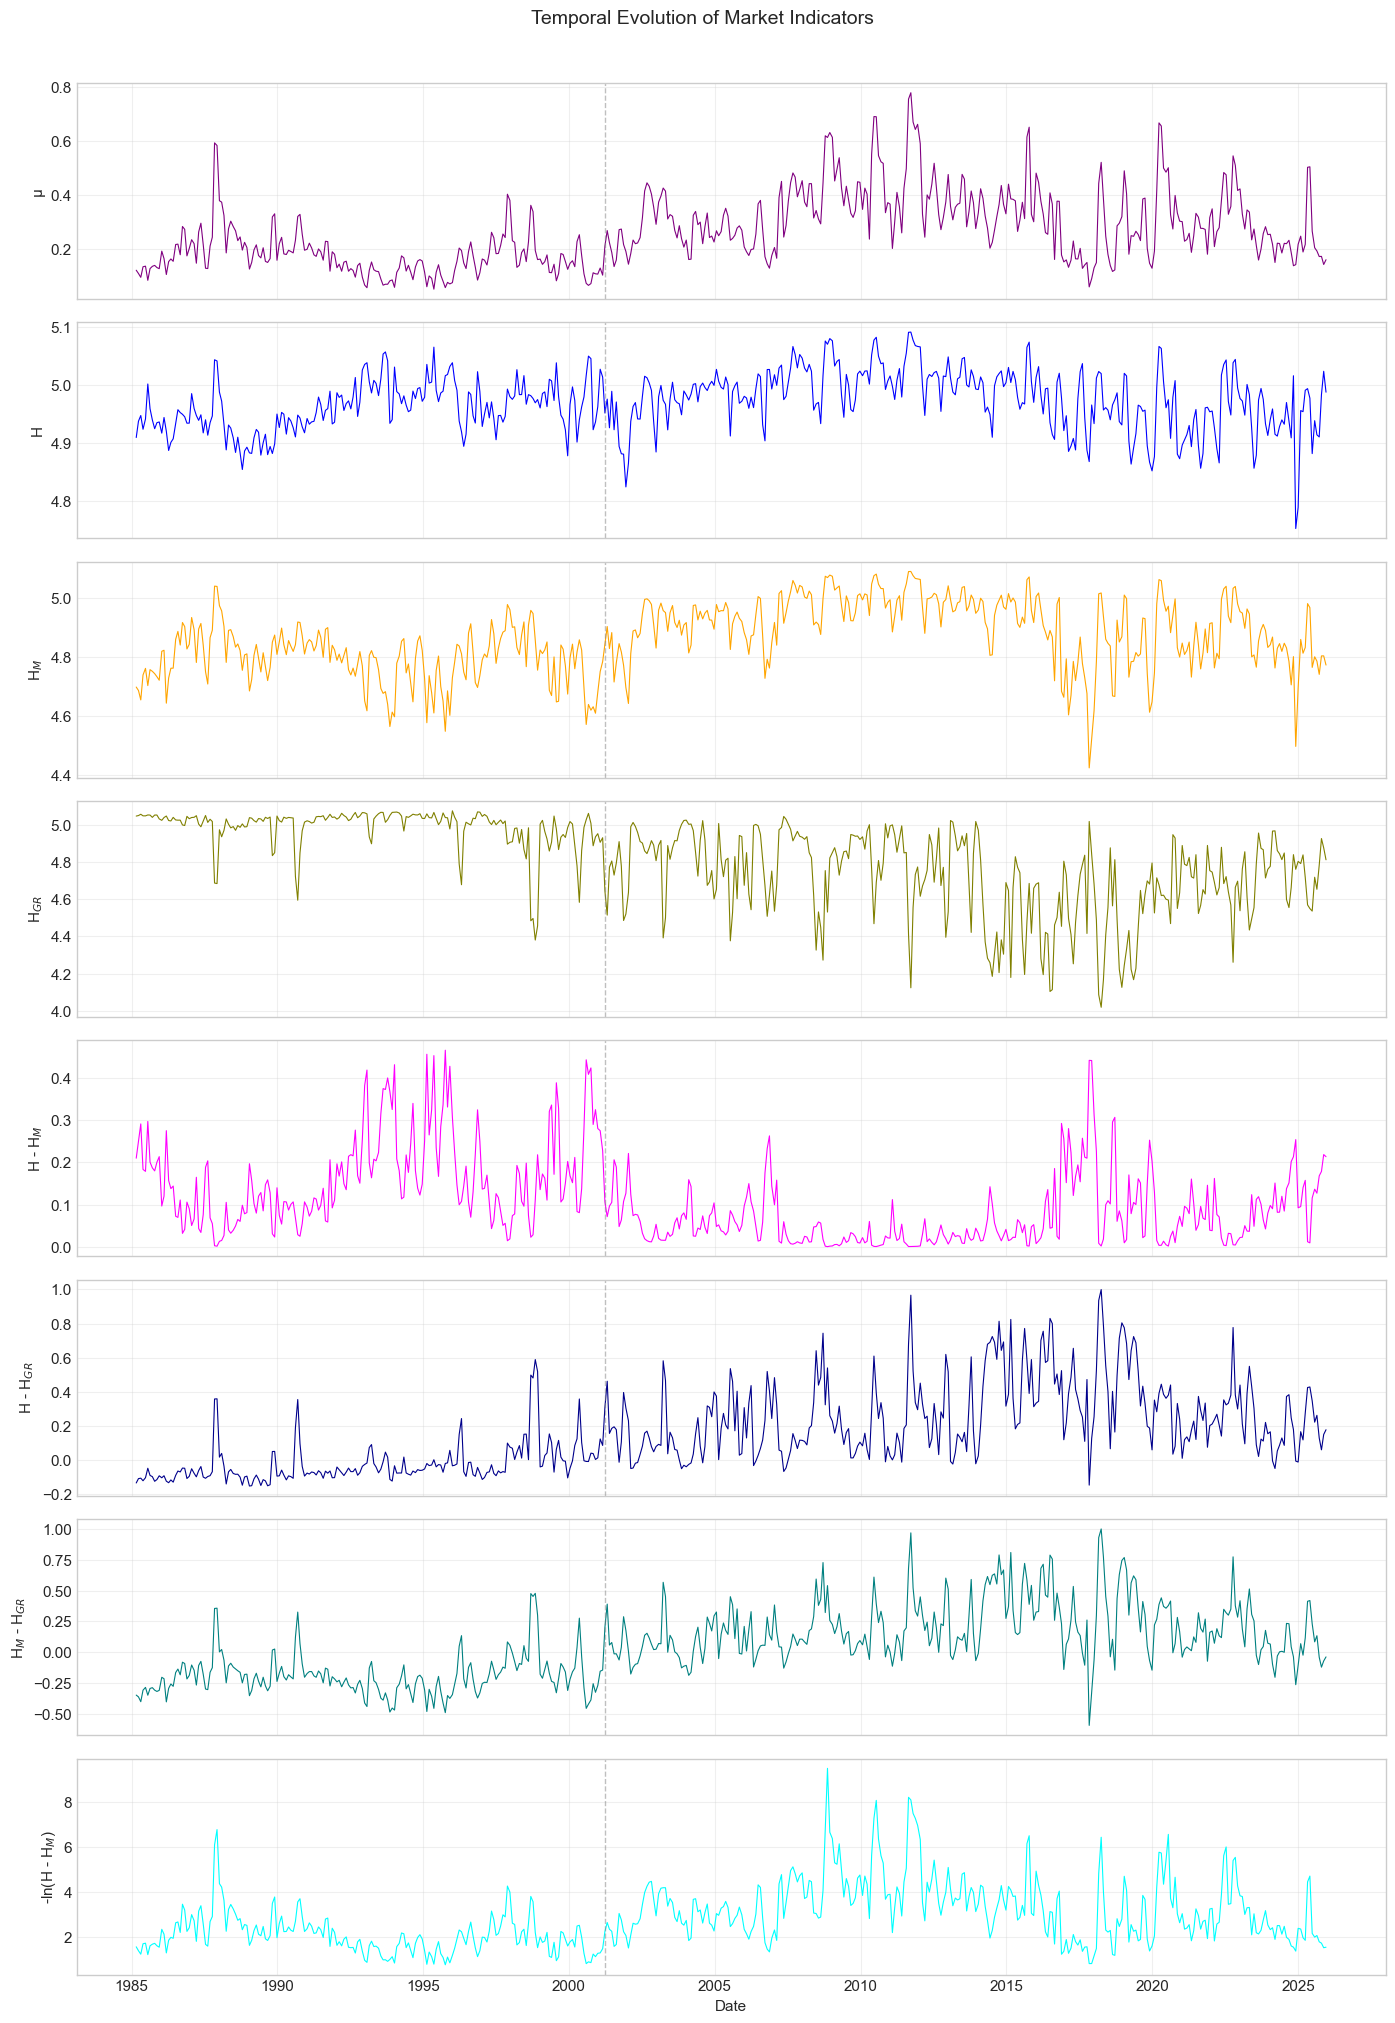

In [17]:

from modules.plot_code import plot_full_temporal_evolution

plot_full_temporal_evolution(results)


Classify epochs into phase-space regimes using fixed quantile thresholds and visualize their distribution and transitions in the entropy phase space.


event_name  event_date      transition_type  \
0        Black Monday  1987-10-19     CRASH TRANSITION   
1        Asian Crisis  1997-10-27   ANOMALY TRANSITION   
2       Dot-com Crash  2000-03-10      TYPE TRANSITION   
3                9/11  2001-09-11  NO CLEAR TRANSITION   
4              Lehman  2008-09-15     CRASH TRANSITION   
5         Flash Crash  2010-05-06     CRASH TRANSITION   
6            Aug 2011  2011-08-08     CRASH TRANSITION   
7  China Black Monday  2015-08-24     CRASH TRANSITION   
8               COVID  2020-02-20     CRASH TRANSITION   

                                            sequence  event_abs_H_minus_HM  \
0  Normal → Normal → Normal → Normal → Crash → Cr...              0.054809   
1  Normal → Normal → Normal → Normal → Normal → A...              0.055558   
2  Normal → Type-2 → Type-2 → Normal → Normal → N...              0.212064   
3  Normal → Normal → Normal → Normal → Normal → N...              0.047756   
4  Normal → Normal → Normal → Crash → Crash → Cra...              0.017347   
5  Crash → Anomaly → Normal → Crash → Crash → Cra...              0.003593   
6  Normal → Normal → Crash → Crash → Crash → Cras...              0.006406   
7  Normal → Normal → Normal → Normal → Crash → Cr...              0.051956   
8  Normal → Normal → Normal → Crash → Crash → Cra...              0.014770   

   event_abs_H_minus_HGR  
0               0.069510  
1               0.073148  
2               0.084118  
3               0.014167  
4               0.743287  
5               0.291710  
6               0.204883  
7               0.771315  
8               0.282091

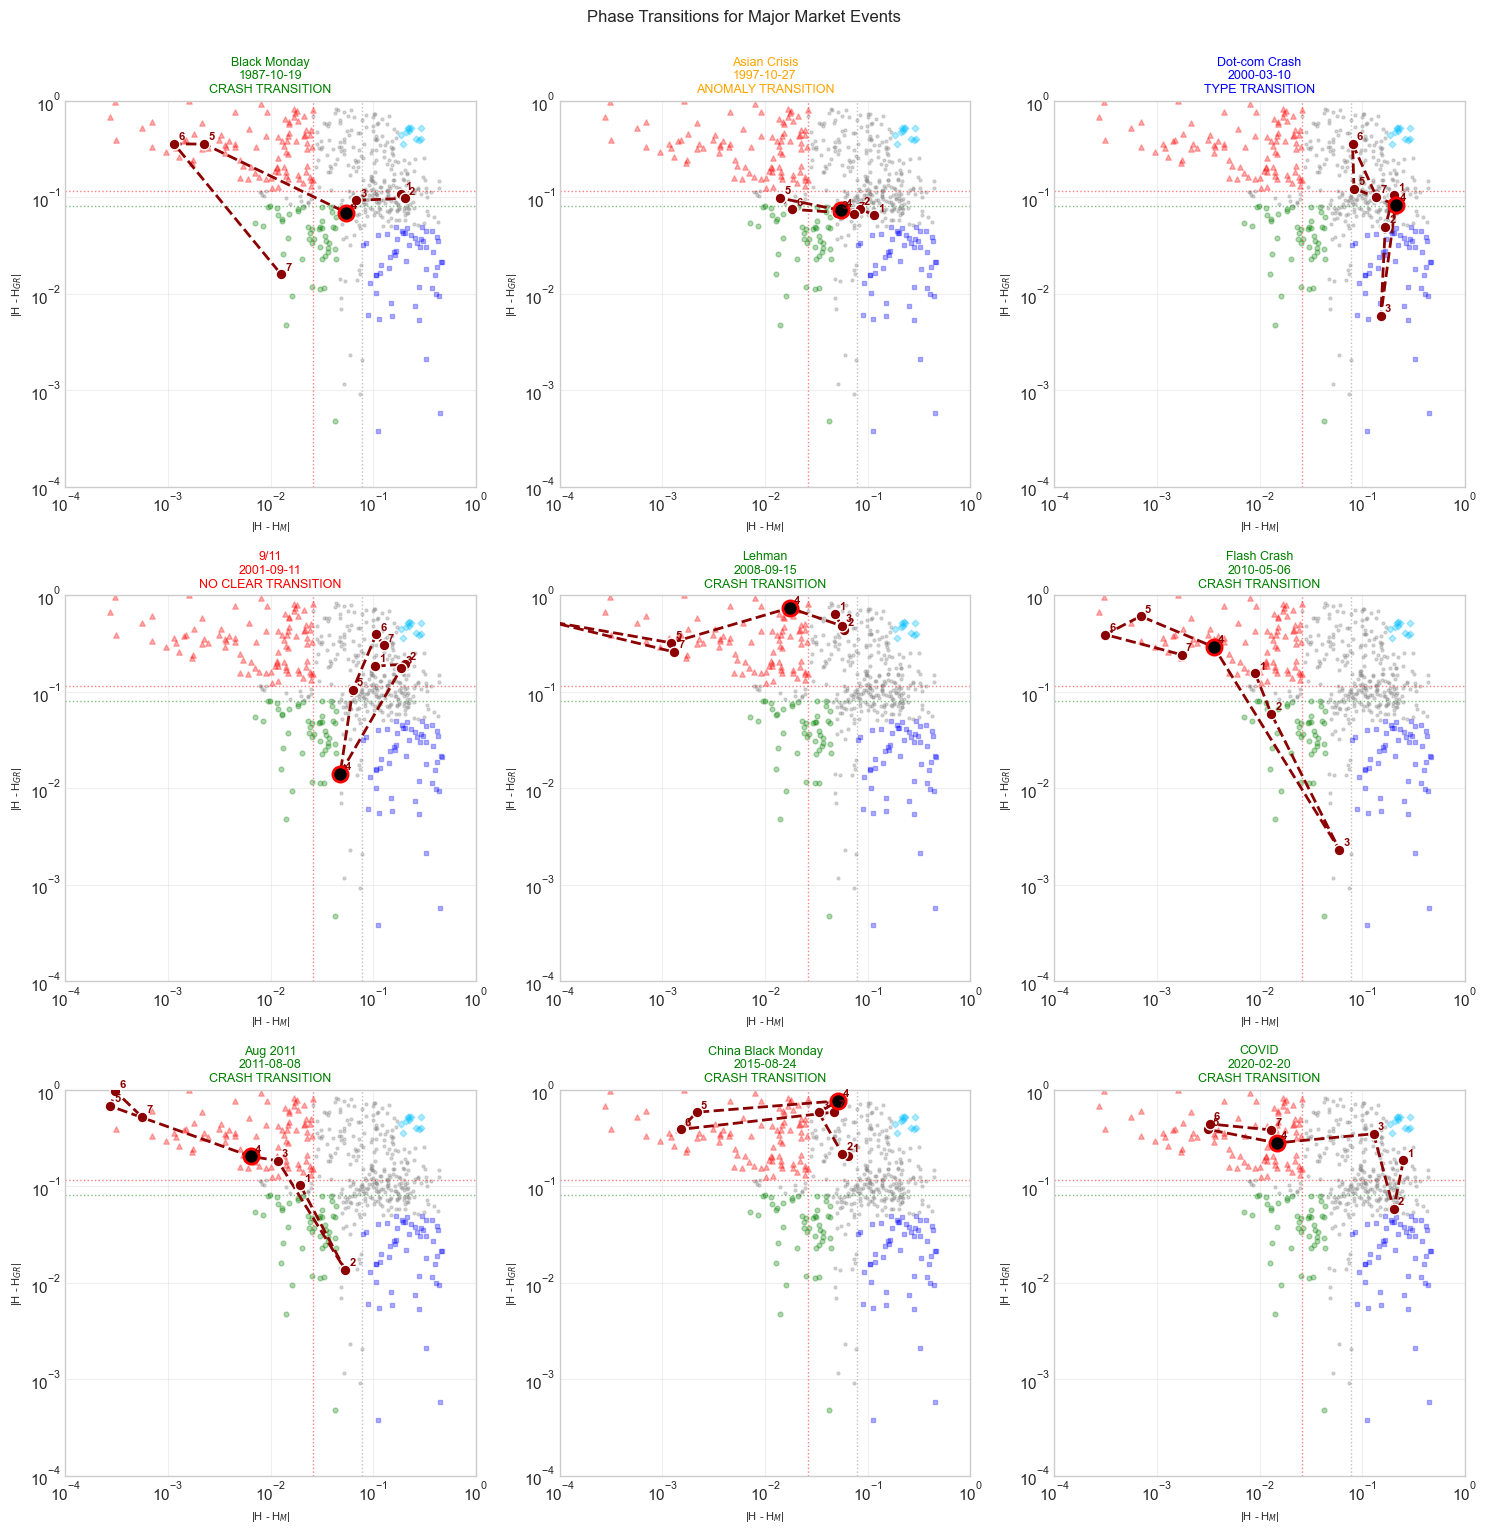

In [18]:
from modules.entropy import assign_phase_regimes_quantiles, summarize_event_transitions
from modules.plot_code import plot_event_transition_grid
from modules.config import CRASH_EVENTS


results_plot, thr = assign_phase_regimes_quantiles(results)

summary = summarize_event_transitions(results_plot, CRASH_EVENTS)
display(summary)

plot_event_transition_grid(results_plot, CRASH_EVENTS, thr, ncols=3, figsize=(15, 15))


RED: Crash Transition (1987-07-16 to 1988-01-06)
     Event date: 1987-10-09
         date phase_regime  abs_H_minus_HM  abs_H_minus_HGR
30 1987-07-16       Normal        0.188629         0.108385
31 1987-08-13       Normal        0.203894         0.097821
32 1987-09-11       Normal        0.068402         0.093034
33 1987-10-09       Normal        0.054809         0.069510
34 1987-11-06        Crash        0.002267         0.357146
35 1987-12-07        Crash        0.001147         0.358108
36 1988-01-06      Anomaly        0.012684         0.015924

BLUE: Type-1→Type-2 Transition (1998-09-10 to 1999-03-04)
      Event date: 1998-12-04
          date phase_regime  abs_H_minus_HM  abs_H_minus_HGR
171 1998-09-10        Crash        0.022369         0.497609
172 1998-10-08       Normal        0.028338         0.480424
173 1998-11-05       Normal        0.111492         0.588643
174 1998-12-04       Type-1        0.218315         0.518365
175 1999-01-05       Type-2        0.135514       

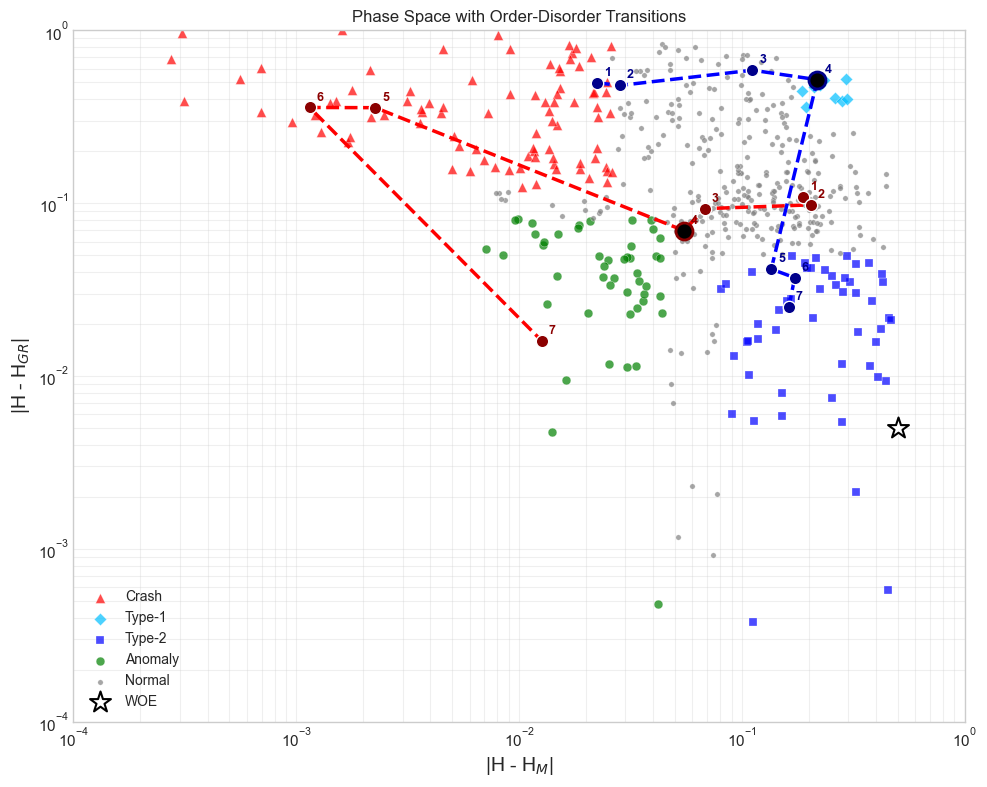

In [19]:
from modules.plot_code import plot_phase_transitions

out = plot_phase_transitions(
    results, print_tables=True,
    woe_point=(0.5, 0.005),
    title="Phase Space with Order-Disorder Transitions",
)

Plot the time evolution of the three entropy measures and compare their behavior around major market crashes.


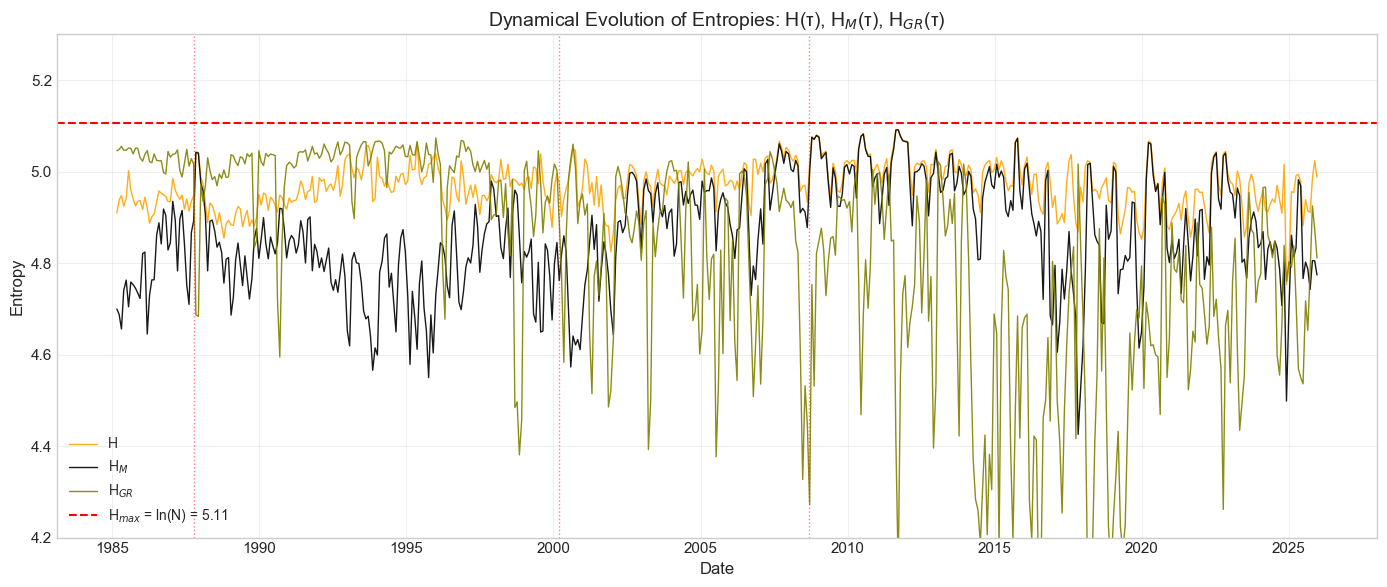

In [20]:
from modules.plot_code import plot_entropy_evolution

plot_entropy_evolution(results, MAJOR_CRASHES, ylim=(4.2, 5.3))


Visualize the entropy phase space in three dimensions, showing the joint structure of the entropy measures across regimes.


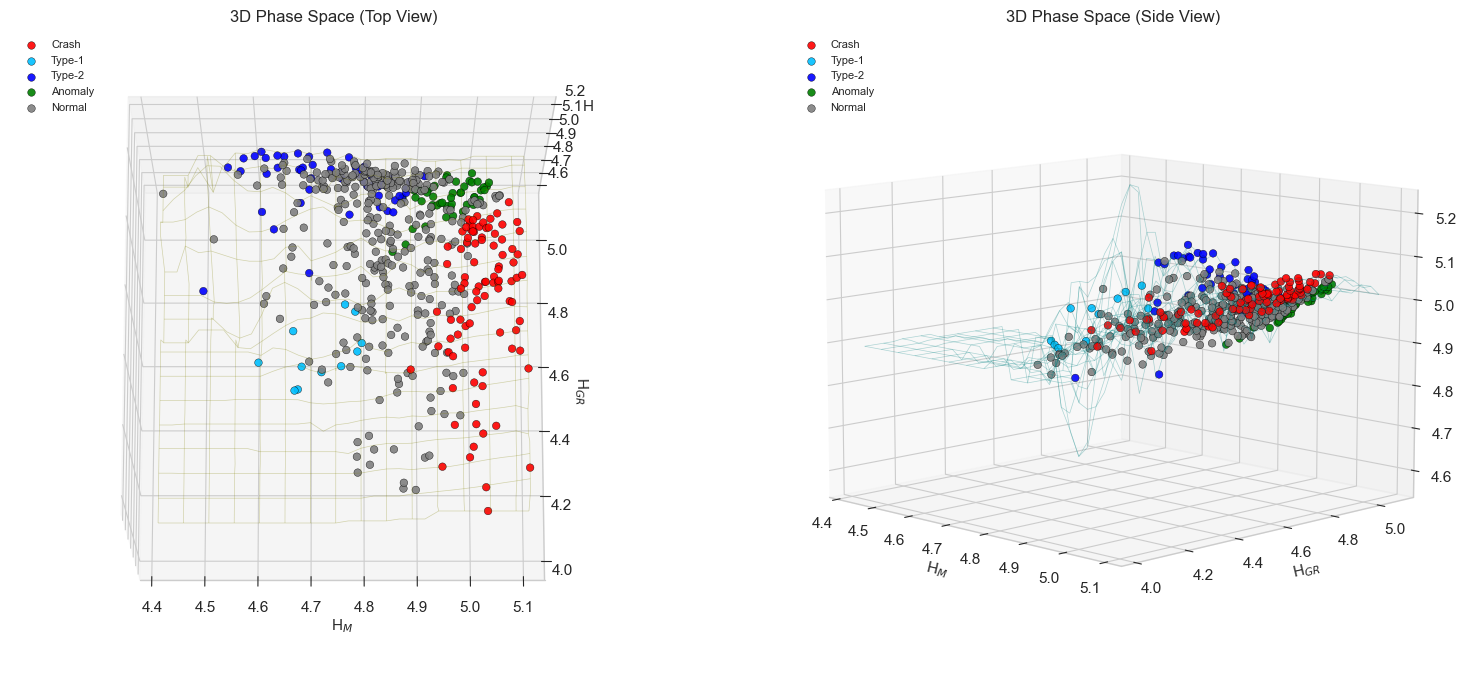

In [21]:
from modules.config import COLORS_3D
from modules.plot_code import plot_3d_phase_space_wireframe

plot_3d_phase_space_wireframe(results_plot, COLORS_3D, grid_n=30)


Visualize the three entropy differences in 3D, colored by phase-space regime.


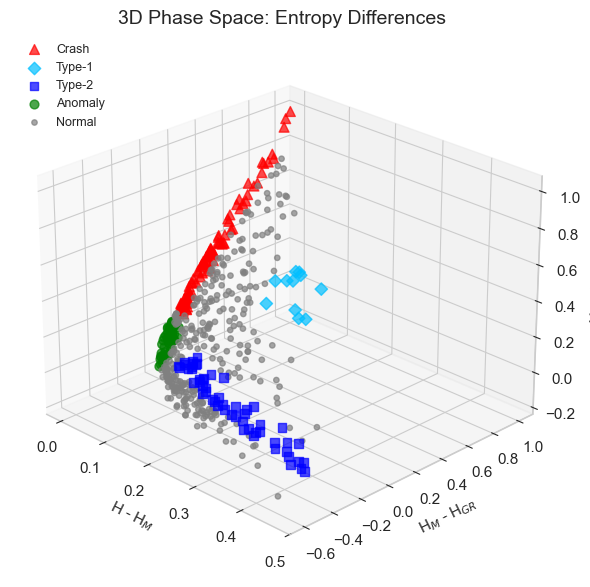

In [23]:
from modules.entropy import assign_phase_regimes_quantiles
from modules.config import PHASE_MARKERS
from modules.plot_code import plot_3d_entropy_differences

results_plot, thresholds = assign_phase_regimes_quantiles(results)
plot_3d_entropy_differences(results_plot, PHASE_MARKERS)


Classify epochs using quantile-based phase-space thresholds and summarize how known crash events are embedded within local phase-space transition sequences.


Evaluate how often known crash events coincide with epochs classified as crash regimes in phase space.


In [ ]:
from modules.plot_code import report_crash_regime_detections
out = report_crash_regime_detections(results, CRASH_EVENTS, window_radius=2)


PHASE SPACE 'CRASH' REGIME DETECTIONS
(LOW |H-H_M| AND HIGH |H-H_GR| simultaneously)

Total epochs classified as 'Crash': 91 out of 515

Crash periods detected:
          date  abs_H_minus_HM  abs_H_minus_HGR
34  1987-11-06        0.002266         0.357146
35  1987-12-07        0.001147         0.358108
171 1998-09-10        0.022370         0.497606
220 2002-08-06        0.018808         0.156732
221 2002-09-04        0.014291         0.168369
222 2002-10-02        0.011893         0.128553
228 2003-03-26        0.015204         0.581547
229 2003-04-24        0.015204         0.466062
231 2003-06-20        0.024489         0.162047
242 2004-05-05        0.024772         0.152817
284 2007-09-06        0.006004         0.153999
291 2008-03-28        0.010991         0.186819
292 2008-04-25        0.011629         0.200848
297 2008-09-17        0.017347         0.743287
298 2008-10-15        0.001208         0.322931
299 2008-11-12        0.000075         0.539605
300 2008-12-11        0

Visualize how entropy-based phase-space crash classifications align with historically known crashes over time.


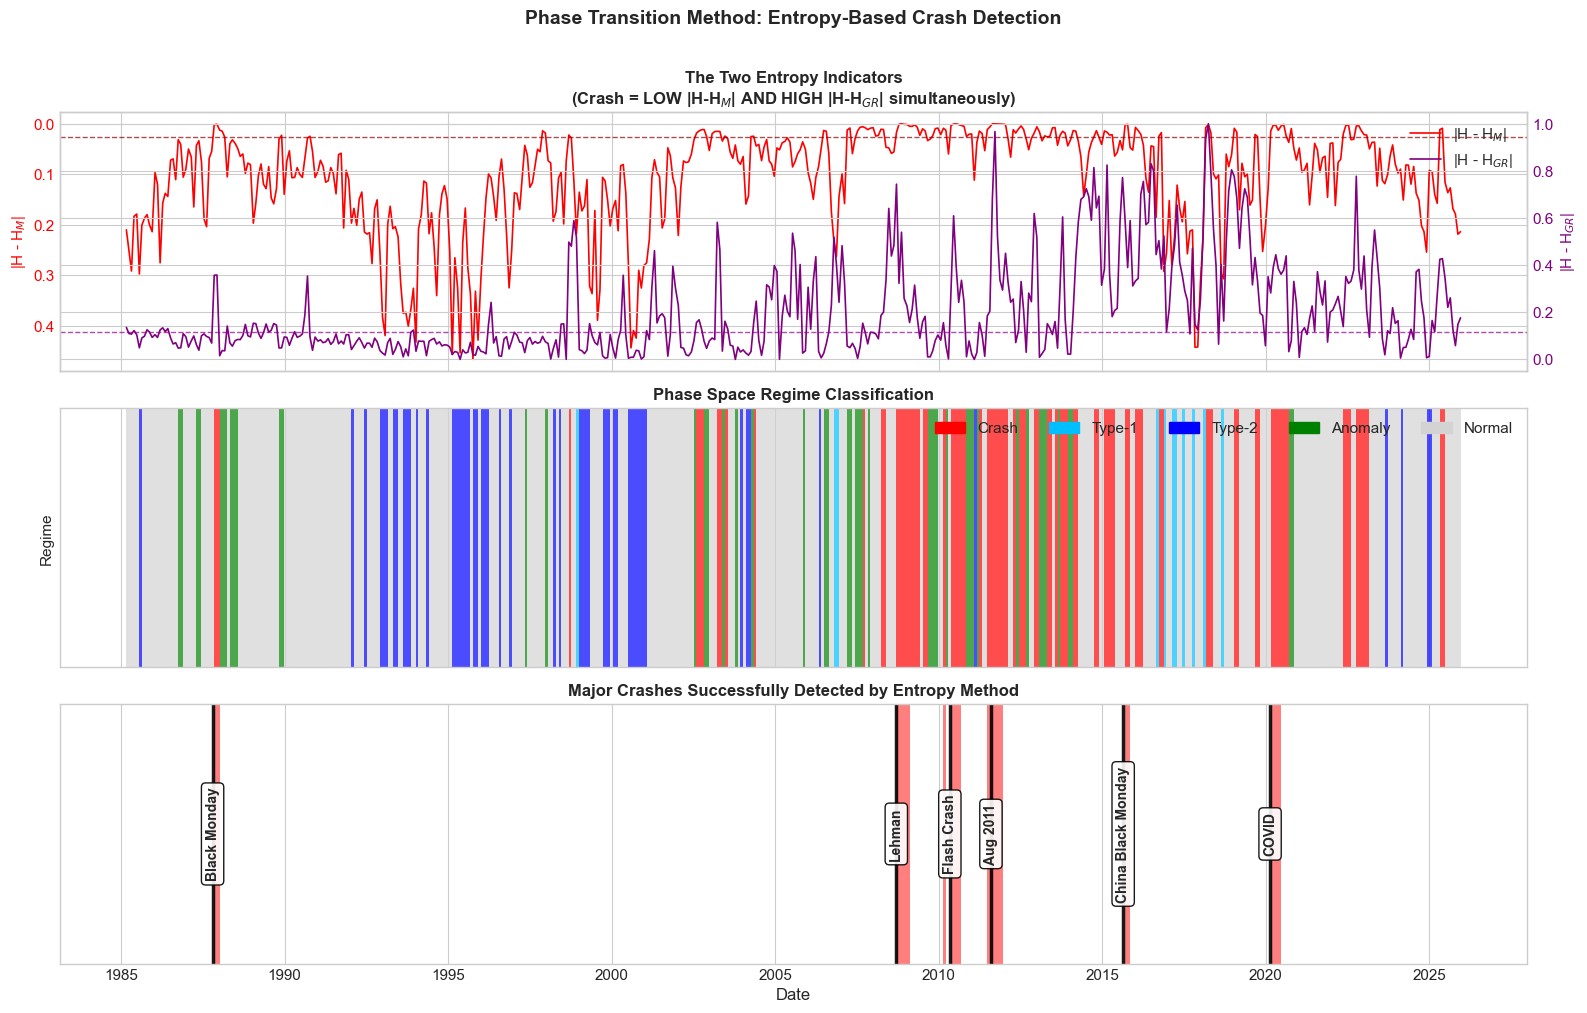

0

In [ ]:
from modules.plot_code import plot_entropy_crash_detection_panels
#get detected crashes from previous cell
WELL_DETECTED_CRASHES = out["well_detected_crashes"]

plot_entropy_crash_detection_panels(results_plot, thr, WELL_DETECTED_CRASHES, days_threshold=120)


---
## Step 7: Summary Statistics and Validation

Summarize entropy values and correlation levels for different labeled market regimes.


In [ ]:
# Summary statistics by regime
print("="*70)
print("SUMMARY STATISTICS BY REGIME")
print("="*70)

for regime in ['normal', 'crash', 'bubble', 'type-1']:
    subset = results[results['regime'] == regime]
    if len(subset) > 0:
        print(f"\n{regime.upper()} (n={len(subset)}):")
        print(f"  H:          mean={subset['H'].mean():.4f}, std={subset['H'].std():.4f}")
        print(f"  H_M:        mean={subset['H_M'].mean():.4f}, std={subset['H_M'].std():.4f}")
        print(f"  H_GR:       mean={subset['H_GR'].mean():.4f}, std={subset['H_GR'].std():.4f}")
        print(f"  |H - H_M|:  mean={subset['abs_H_minus_HM'].mean():.4f}")
        print(f"  |H - H_GR|: mean={subset['abs_H_minus_HGR'].mean():.4f}")
        print(f"  μ (corr):   mean={subset['mu'].mean():.4f}, std={subset['mu'].std():.4f}")

SUMMARY STATISTICS BY REGIME

NORMAL (n=430):
  H:          mean=4.9704, std=0.0507
  H_M:        mean=4.8609, std=0.1210
  H_GR:       mean=4.8167, std=0.2429
  |H - H_M|:  mean=0.1094
  |H - H_GR|: mean=0.2059
  μ (corr):   mean=0.2636, std=0.1358

CRASH (n=24):
  H:          mean=4.9732, std=0.0612
  H_M:        mean=4.9180, std=0.1019
  H_GR:       mean=4.8158, std=0.2221
  |H - H_M|:  mean=0.0552
  |H - H_GR|: mean=0.2250
  μ (corr):   mean=0.3448, std=0.1768

BUBBLE (n=60):
  H:          mean=4.9732, std=0.0462
  H_M:        mean=4.8662, std=0.0987
  H_GR:       mean=4.8243, std=0.1710
  |H - H_M|:  mean=0.1069
  |H - H_GR|: mean=0.1650
  μ (corr):   mean=0.2400, std=0.0905

TYPE-1 (n=1):
  H:          mean=4.9781, std=nan
  H_M:        mean=4.6852, std=nan
  H_GR:       mean=4.4543, std=nan
  |H - H_M|:  mean=0.2928
  |H - H_GR|: mean=0.5237
  μ (corr):   mean=0.1791, std=nan
